# The medial flow tracker

In this recipe, we're going to apply the Median Flow object tracker to track objects in a video. This tracker works in real time (even faster on modern hardware) and does its job accurately and steadily. Also, this tracker has a nice feature, it can determine the tracking failure. 



In [1]:
# Import all of the necessary modules
import cv2
import matplotlib.pyplot as plt
import numpy as np

%matplotlib auto
%pylab inline


def print_image(header,name,np_arr,start_First=0, end_First=1, start_Second=0, end_Second=2):
    print("------  {0:-<25}    Shape{1} {2}: {3:}".format(header, np_arr.shape, name, str(np_arr.dtype)) )
    shapes = np_arr.shape #print(shapes)
    if shapes[0] < end_First:
        end_First = shapes[0]
    if shapes[1] < end_Second:
        end_Second = shapes[1]
    if len(shapes)==3:
        for i in range (start_First,end_First):
            print("[", end=" ")
            for k in range (start_Second,end_Second):
                print(np_arr[i,k], end=" ")
            print(']')
    if len(shapes)==2:
        for i in range (start_First,end_First):
            print("[", end=" ")
            for k in range (start_Second,end_Second):
                print(np_arr[i,k], end=" ")
            print(']')
def plt_view_image(plt,list_images,figsize=(15,6), axis="off", cmap='gray'):
    #%pylab inline
    plt.figure(figsize=figsize)
    n = len(list_images)  #; print(n)
    plot_number = 1
    for name, img in list_images:
        plt.subplot(1,n,plot_number)
        plt.axis(axis)
        plt.title(name)
        if cmap =='gray':
            plt.imshow(img,cmap='gray' )
        else:
            plt.imshow(img )
        plot_number = plot_number + 1
    plt.show()
#help("modules")   
import sys             
print('\n'.join(sys.path))
#pip list"

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib
D:\HTML_DOC\Program\opencv\Packt\S04\env
C:\Program Files\Python38\python38.zip
C:\Program Files\Python38\DLLs
C:\Program Files\Python38\lib
C:\Program Files\Python38
d:\html_doc\program\opencv\packt\s04\env

d:\html_doc\program\opencv\packt\s04\env\lib\site-packages
d:\html_doc\program\opencv\packt\s04\env\lib\site-packages\pip-20.0.2-py3.8.egg
d:\html_doc\program\opencv\packt\s04\env\lib\site-packages\win32
d:\html_doc\program\opencv\packt\s04\env\lib\site-packages\win32\lib
d:\html_doc\program\opencv\packt\s04\env\lib\site-packages\Pythonwin
d:\html_doc\program\opencv\packt\s04\env\lib\site-packages\IPython\extensions
C:\Users\polit\.ipython


In [2]:
# Open a video file, read its frame, and select an object to track
cap = cv2.VideoCapture("../data/traffic.mp4")

print('Created capture:', '../data/traffic.mp4')
print('Frame count:', int(cap.get(cv2.CAP_PROP_FRAME_COUNT)))
print('Frame width:', int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)))
print('Frame height:', int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
print('Frame rate:', cap.get(cv2.CAP_PROP_FPS))


status_cap, frame = cap.read()

# Function creates a window and allows user to select a ROI using mouse
#   Controls: use `space` or `enter` to finish selection, 
#   use key `c` to cancel selection (function will return the zero cv::Rect)
#
#cv2.selectROI(windowName, img[, showCrosshair[, fromCenter]]) -> retval
#  windowName - name of the window where selection process will be shown.
#  img - image to select a ROI.
#  showCrosshair - if true crosshair of selection rectangle will be shown.
#  fromCenter - if true center of selection will match initial mouse position. In opposite case a corner of 
#               selection rectangle will correspont to the initial mouse position.
#If you are like me, you would prefer to drag a rectangle from the top left corner to the bottom right corner 
#instead of the dragging it from the center. 
#boundingBox = cv2.selectROI(frame, False, True)
showCrosshair = True
fromCenter = False
boundingBox = cv2.selectROI(frame, showCrosshair, fromCenter);
print(boundingBox)

cv2.destroyAllWindows()

Created capture: ../data/traffic.mp4
Frame count: 1501
Frame width: 1920
Frame height: 1080
Frame rate: 25.0
(274, 298, 134, 84)


# [Object Tracking using OpenCV (C++/Python)](https://www.learnopencv.com/object-tracking-using-opencv-cpp-python/)

### MEDIANFLOW Tracker

Internally, this tracker tracks the object in both forward and backward directions in time and measures the discrepancies between these two trajectories. Minimizing this ForwardBackward error enables them to reliably detect tracking failures and select reliable trajectories in video sequences.

In my tests, I found this tracker works best when the motion is predictable and small. Unlike, other trackers that keep going even when the tracking has clearly failed, this tracker knows when the tracking has failed.

__Pros__ : Excellent tracking failure reporting. Works very well when the motion is predictable and there is no occlusion.

__Cons__ : Fails under large motion.

# [OpenCV Object Tracking](https://www.pyimagesearch.com/2018/07/30/opencv-object-tracking/)

You might be surprised to know that OpenCV includes eight (yes, eight!) separate object tracking implementations that you can use in your own computer vision applications.

I’ve included a brief highlight of each object tracker below:

1) __BOOSTING Tracker__: Based on the same algorithm used to power the machine learning behind Haar cascades (AdaBoost), but like Haar cascades, is over a decade old. This tracker is slow and doesn’t work very well. Interesting only for legacy reasons and comparing other algorithms. (minimum OpenCV 3.0.0)

2) __MIL Tracker__: Better accuracy than BOOSTING tracker but does a poor job of reporting failure. (minimum OpenCV 3.0.0)

3) __KCF Tracker__: Kernelized Correlation Filters. Faster than BOOSTING and MIL. Similar to MIL and KCF, does not handle full occlusion well. (minimum OpenCV 3.1.0)

4) __CSRT Tracker__: Discriminative Correlation Filter (with Channel and Spatial Reliability). Tends to be more accurate than KCF but slightly slower. (minimum OpenCV 3.4.2)

5) __MedianFlow Tracker__: Does a nice job reporting failures; however, if there is too large of a jump in motion, such as fast moving objects, or objects that change quickly in their appearance, the model will fail. (minimum OpenCV 3.0.0)

6) __TLD Tracker__: I’m not sure if there is a problem with the OpenCV implementation of the TLD tracker or the actual algorithm itself, but the TLD tracker was incredibly prone to false-positives. I do not recommend using this OpenCV object tracker. (minimum OpenCV 3.0.0)

7) __MOSSE Tracker__: Very, very fast. Not as accurate as CSRT or KCF but a good choice if you need pure speed. (minimum OpenCV 3.4.1)

8) __GOTURN Tracker__: The only deep learning-based object detector included in OpenCV. It requires additional model files to run (will not be covered in this post). My initial experiments showed it was a bit of a pain to use even though it reportedly handles viewing changes well (my initial experiments didn’t confirm this though). I’ll try to cover it in a future post, but in the meantime, take a look at Satya’s writeup. (minimum OpenCV 3.2.0)
    Notice : GOTURN being a CNN based tracker, uses a caffe model for tracking. The Caffe model and the proto text file must be present in the directory in which the code is present. These files can also be downloaded from the opencv_extra repository, concatenated and extracted before use.
    Update: GOTURN object tracking algorithm has been ported to OpenCV. We have a separate blog post on it’s implementation [here](https://www.learnopencv.com/goturn-deep-learning-based-object-tracking/)

My personal suggestion is to:

* Use __CSRT__ when you need higher object tracking accuracy and can tolerate slower FPS throughput
* Use __KCF__ when you need faster FPS throughput but can handle slightly lower object tracking accuracy
* Use __MOSSE__ when you need pure speed

Create the Median Flow tracker and initialize it with the first frame from the video and the bounding box we've selected. Then, read the remaining frames one-by-one, feed them into the tracker, and get a new bounding box for each frame. Display the bounding box, as well as the number of frames that the Median Flow algorithm is able to process each second:

30


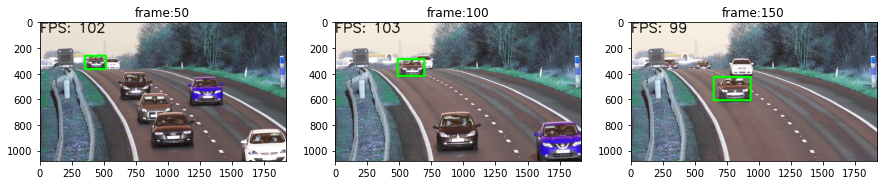

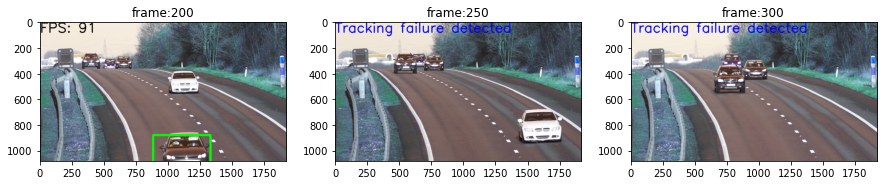

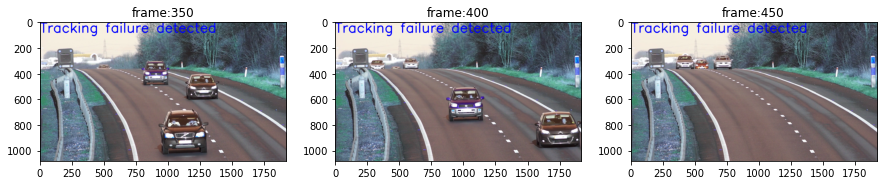

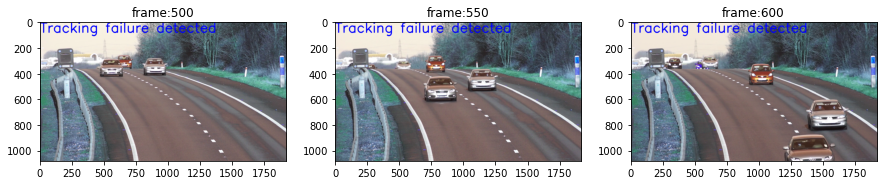

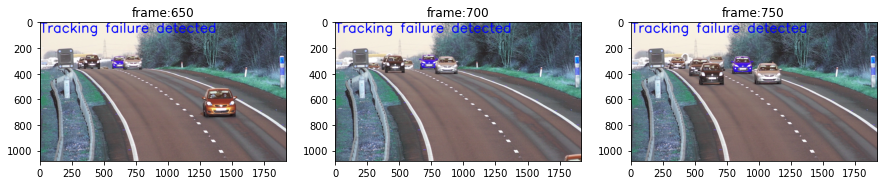

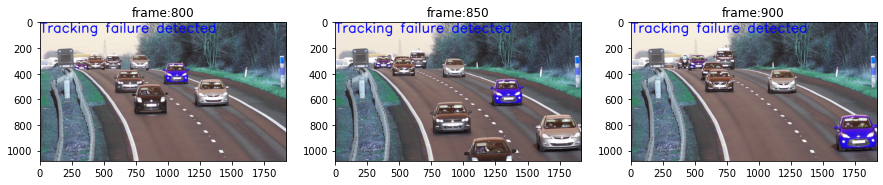

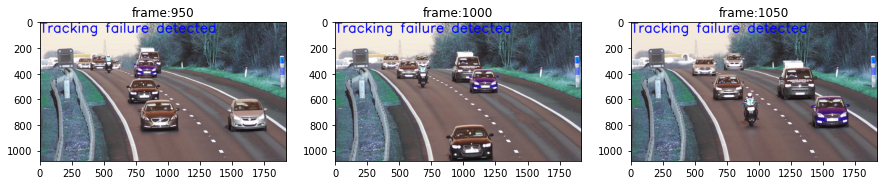

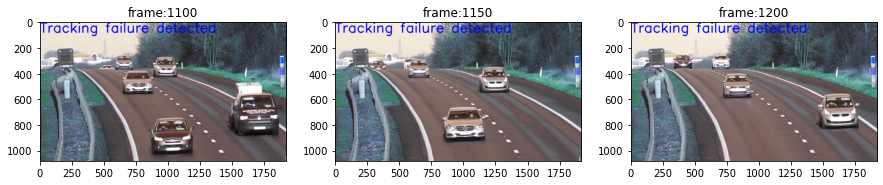

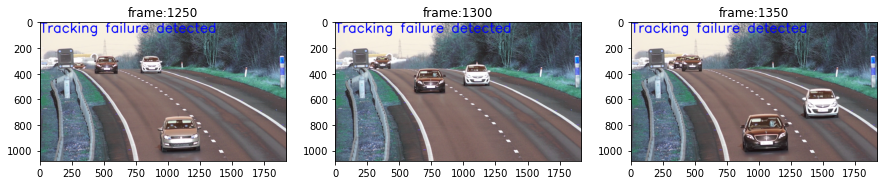

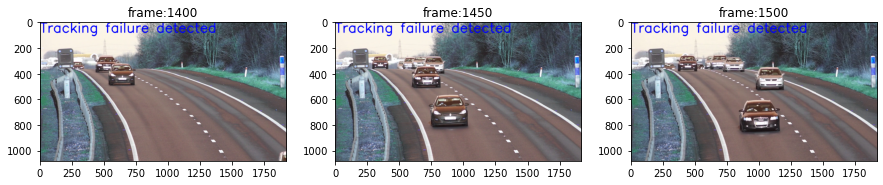

In [3]:
# Create the Median Flow tracker 
tracker = cv2.TrackerMedianFlow_create()

# Initialize it with the first frame from the video and the bounding box
#retval = cv.Tracker.init(image, boundingBox)
#  image - The initial frame
#  boundingBox - The initial bounding box
status_tracker = tracker.init(frame, boundingBox)
fps = 0

# Then, read the remaining frames one-by-one, 
# feed them into the tracker, 
# and get a new bounding box for each frame

#Update the tracker, find the new most likely bounding box for the target.
#status_tracker, boundingBox = cv.Tracker.update(image)
#  image - The current frame
#  boundingBox - The bounding box that represent the new target location, if true was returned, not modified otherwise
#  status_tracker - True means that target was located 
#                   False means that tracker cannot locate target in current frame. 
#                   Note, that latter does not imply that tracker has failed, maybe target is indeed missing from the frame (say, out of sight)

count = 0
image_frames =[]

while True:
    status_cap, frame = cap.read()
    count += 1
    if not status_cap:
        break
    
    if count % 50 == 0:
        image_frames.append(["frame:{}".format(count),frame])
        
    if status_tracker:
        timer = cv2.getTickCount()
        status_tracker, boundingBox = tracker.update(frame)
        
    if status_tracker:
        x, y, w, h = [int(i) for i in boundingBox]
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 15)
        fps = cv2.getTickFrequency() / (cv2.getTickCount() - timer);
        cv2.putText(frame, "FPS: %.0f" % fps, (0, 80), cv2.FONT_HERSHEY_SIMPLEX, 3.5, (0, 0, 0), 8);
    else:
        cv2.putText(frame, "Tracking failure detected", (0, 80), cv2.FONT_HERSHEY_SIMPLEX, 3.5, (0,0,255), 8)
        
    cv2.imshow("MedianFlow tracker", frame)

    k = cv2.waitKey(1)
    
    if k == 27: 
        break
    
cv2.destroyAllWindows()

print(len(image_frames))
#plt_view_image(plt,[[i[0],i[1]] for i in image_frames])  
#plt_view_image(plt,images, figsize=(5,5), axis='on', cmap='gray')
k =3
for i in range(0,len(image_frames),k):
    plt_view_image(plt,image_frames[i:i+k], figsize=(15,8), axis='on', cmap='gray')